In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
maindir = "/content/drive/MyDrive/ids_data/"

In [2]:
columns_df = pd.DataFrame()
df = pd.read_csv(maindir + "kdd.names.txt", header=None)
columns_df["column_names"] = [x.split(":")[0] for x in df[0]] + ["class"]
columns_df["column_data_types"] = [x.split(":")[1] for x in df[0]] + ["str"]
columns_df.shape

(42, 2)

In [3]:
data_df = pd.read_csv(maindir + "kddcup.data.gz", header=None)
data_df.shape

(4898431, 42)

In [4]:
columns_names = {}
for idx, column in enumerate(list(columns_df["column_names"])):
  columns_names[idx] = column
data_df = data_df.rename(columns=columns_names)
data_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
#Removing the punctuation at the end of the line
data_df["class"] = [x[:-1] for x in list(data_df["class"])]

In [6]:
attacks = {}
df = pd.read_csv(maindir + "attack_types.txt", header=None)
for attack in df[0]:
  attack_type, super_group = attack.split(" ")
  attacks[attack_type] = super_group

#Adding normal class to the list of attacks to ensure that all packets are cns
attacks["normal"] = "normal"
#We wil be using the super group values for a 5 class classification
attacks

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'normal': 'normal',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}

In [7]:
data_df['class'] = data_df['class'].map(attacks)

In [8]:
# List of five classes
set(list(data_df['class']))

{'dos', 'normal', 'probe', 'r2l', 'u2r'}

## Data Analysis

In [9]:
data_df = data_df.dropna('columns')
data_df.shape

(4898431, 42)

In [10]:
#Keep columns with unique values
data_df = data_df[[col for col in data_df if data_df[col].nunique() > 1]]
data_df.shape

(4898431, 41)

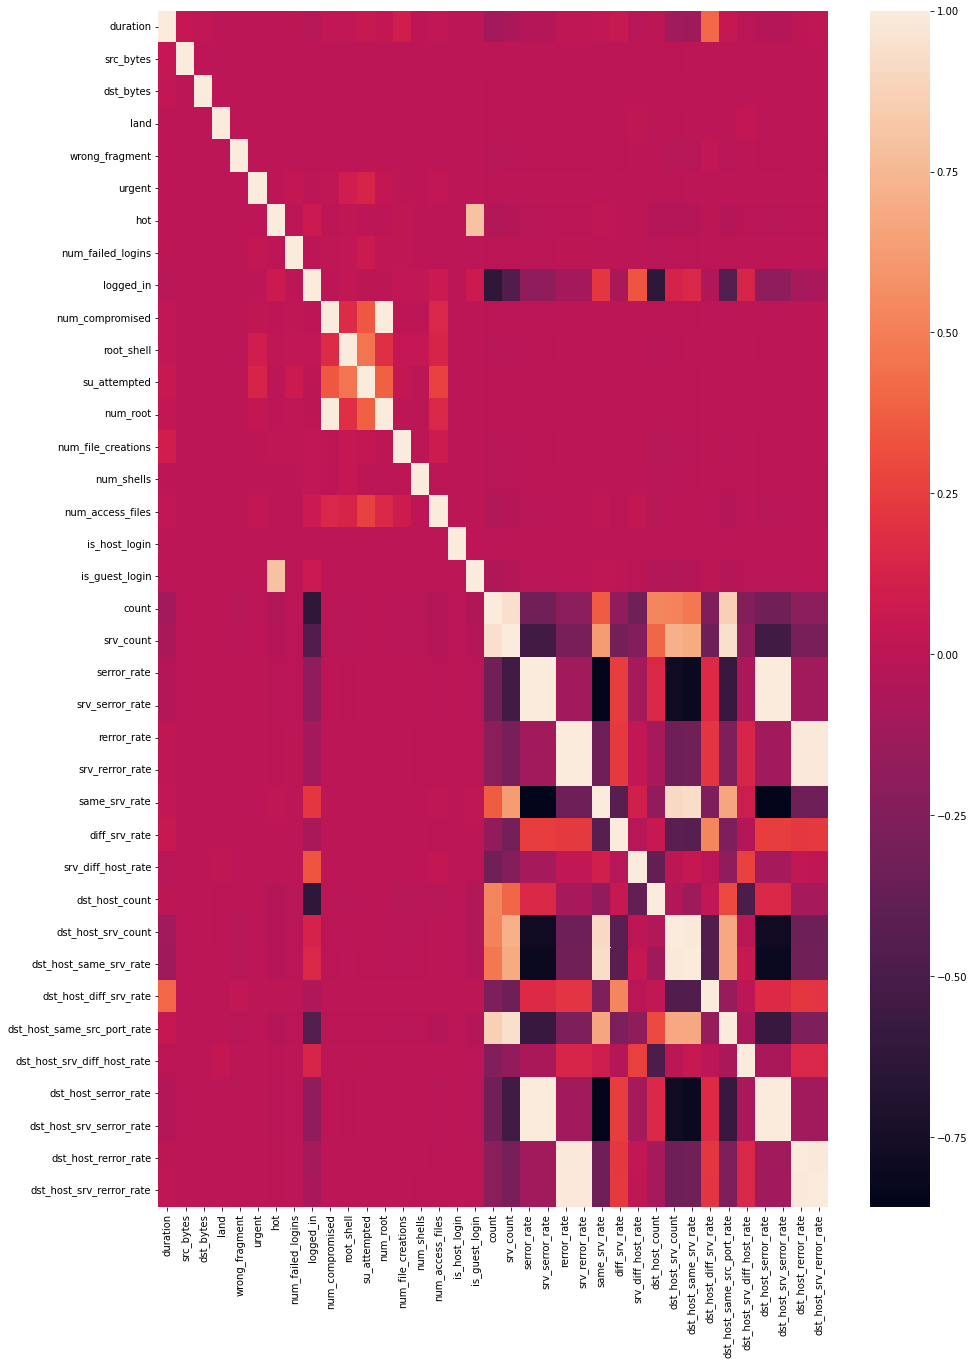

In [11]:
#Generate a correlation matrix to remove the features that are not significant
corr_matrix = data_df.corr()
plt.figure(figsize=(15, 22))
sns.heatmap(corr_matrix)
plt.show()

In [12]:
# Removing columns that have a high correlation rate
data_df.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)
  
data_df.drop('dst_host_serror_rate', axis = 1, inplace = True)
  
data_df.drop('dst_host_rerror_rate', axis = 1, inplace = True)
  
data_df.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)
  
data_df.drop('dst_host_same_srv_rate', axis = 1, inplace = True)

data_df.drop('num_root', axis = 1, inplace = True)
  
data_df.drop('srv_serror_rate', axis = 1, inplace = True)
  
data_df.drop('srv_rerror_rate', axis = 1, inplace = True)

# The service columns has non-relvant information for our analysis
data_df.drop('service', axis = 1, inplace = True)

data_df.shape

(4898431, 32)

In [13]:
protocol_type = {}
idx = 0
for protocol in data_df["protocol_type"]:
  if protocol not in protocol_type:
    protocol_type[protocol] = idx
    idx += 1

flags = {}
idx = 0
for flag in data_df["flag"]:
  if flag not in flags:
    flags[flag] = idx
    idx += 1

data_df['protocol_type'] = data_df['protocol_type'].map(protocol_type)
data_df['flag'] = data_df['flag'].map(flags)

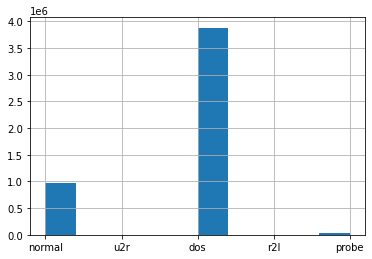

In [14]:
# The classes are clearly not equally distributed
data_df["class"].hist()

In [15]:
# Classes for classification
packet_type = {}
idx = 0
for packet in data_df["class"]:
  if packet not in packet_type:
    packet_type[packet] = idx
    idx += 1

packet_type

{'dos': 2, 'normal': 0, 'probe': 4, 'r2l': 3, 'u2r': 1}

In [16]:
data_df['class'] = data_df['class'].map(packet_type)

## Prepare for ML training

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [18]:
y = data_df[['class']]
x = data_df.drop(['class', ], axis = 1)

x.shape

(4898431, 31)

In [19]:
sc = MinMaxScaler()
x = sc.fit_transform(x)

In [20]:
# Split test and train data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 47)
print("Data shape : Train , Test")
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

Data shape : Train , Test
(3428901, 31) (1469530, 31)
(3428901, 1) (1469530, 1)


## Apply the ML algorithms

### Decision Tree

In [21]:
dt_classif = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)

#Fit the data
dt_classif.fit(x_train, y_train.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [22]:
y_train_pred = dt_classif.predict(x_train)
y_test_pred = dt_classif.predict(x_test)

In [23]:
print("Training accuracy for Decision Tree : {}". format(accuracy_score(y_train, y_train_pred)))
print("Test accuracy for Decision Tree : {}". format(accuracy_score(y_test, y_test_pred)))

Training accuracy for Decision Tree : 0.9965837450541734
Test accuracy for Decision Tree : 0.9965295026300927


### Random Forest

In [25]:
rf_classif = RandomForestClassifier(n_estimators = 100)

#Fit the data
rf_classif.fit(x_train, y_train.values.ravel())

RandomForestClassifier()

In [28]:
y_train_pred = rf_classif.predict(x_train)
y_test_pred = rf_classif.predict(x_test)

In [29]:
print("Training accuracy for Random Forest : {}". format(accuracy_score(y_train, y_train_pred)))
print("Test accuracy for Random Forest : {}". format(accuracy_score(y_test, y_test_pred)))

Training accuracy for Random Forest : 0.9999632535322542
Test accuracy for Random Forest : 0.9998952045892224


## Naive Bayes

In [30]:
nb_classif = GaussianNB()

#Fit the data
nb_classif.fit(x_train, y_train.values.ravel())

GaussianNB()

In [31]:
y_train_pred = nb_classif.predict(x_train)
y_test_pred = nb_classif.predict(x_test)

In [32]:
print("Training accuracy for Naive Bayes : {}". format(accuracy_score(y_train, y_train_pred)))
print("Test accuracy for Naive Bayes : {}". format(accuracy_score(y_test, y_test_pred)))

Training accuracy for Naive Bayes : 0.9239666003772055
Test accuracy for Naive Bayes : 0.9238225827305329
